# IEEE-CIS Fraud Detection — 01 Exploratory Data Analysis & Roadmap

This notebook performs an initial exploratory analysis of the IEEE-CIS Fraud Detection dataset and defines the roadmap for feature engineering and modeling. All sections are written in English for reproducibility and portfolio presentation.

In [1]:
# Basic imports and plotting setup
import os, traceback
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.05)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_columns', 200)

## Data loading

The code below attempts to download the competition data using `kagglehub`. If that fails, it will attempt to read local files from `../data/`. The notebook prints helpful diagnostics to debug Kaggle access issues.

In [2]:
import kagglehub
kagglehub.login()

In [3]:
# Load IEEE-CIS data (train_transaction + train_identity)
from pathlib import Path
cwd = Path.cwd()
print(f'Working directory: {cwd}')

def load_data():
    # Use kagglehub to download competition files and fail loudly if unavailable
    try:
        print('Attempting kagglehub download...')
        data_dir = Path(kagglehub.competition_download('ieee-fraud-detection'))
        tx_path = data_dir / 'train_transaction.csv'
        id_path = data_dir / 'train_identity.csv'
        print('kagglehub returned:', data_dir)
        if tx_path.exists() and id_path.exists():
            return pd.read_csv(tx_path), pd.read_csv(id_path)
        else:
            raise FileNotFoundError(f'Expected files not found under {data_dir}')
    except Exception:
        print('kagglehub failed or is not available. See traceback for details:')
        traceback.print_exc()
        raise RuntimeError(
            'kagglehub could not download the competition data.\n'
            'Please ensure you have joined the IEEE-CIS competition on Kaggle and configured credentials for kagglehub/kaggle.\n'
            'Alternatively, download `train_transaction.csv` and `train_identity.csv` manually from Kaggle and load them explicitly.'
        )

# Execute load
train_txn, train_id = load_data()
print(f'Loaded transactions: {len(train_txn):,}, identities: {len(train_id):,}')

# Merge
df = train_txn.merge(train_id, on='TransactionID', how='left')
del train_txn, train_id
print(f'Merged dataframe: {df.shape[0]:,} rows x {df.shape[1]} columns')


Working directory: c:\Users\rvito\code\personal\public_projects\Fraud Detection\notebooks
Attempting kagglehub download...
kagglehub returned: C:\Users\rvito\.cache\kagglehub\competitions\ieee-fraud-detection
Loaded transactions: 590,540, identities: 144,233
Merged dataframe: 590,540 rows x 434 columns


## 1 — Data Overview

Show shape, memory usage and a quick head of the merged dataset.

In [4]:
print('Shape:', df.shape)
print('Memory (GB):', df.memory_usage(deep=True).sum() / 1e9)
print('\nDtype counts:')
print(df.dtypes.value_counts())

# show sample rows
df.head(3)


Shape: (590540, 434)
Memory (GB): 2.080582559

Dtype counts:
float64    399
str         31
int64        4
Name: count, dtype: int64


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5000,W,13926,NaN,150.0000,discover,142.0000,credit,315.0000,87.0000,19.0000,NaN,NaN,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,2.0000,0.0000,1.0000,1.0000,14.0000,NaN,13.0000,NaN,NaN,NaN,NaN,NaN,NaN,13.0000,13.0000,NaN,NaN,NaN,0.0000,T,T,T,M2,F,T,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,117.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,117.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0000,W,2755,404.0000,150.0000,mastercard,102.0000,credit,325.0000,87.0000,NaN,NaN,gmail.com,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,...,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0000,W,4663,490.0000,150.0000,visa,166.0000,debit,330.0000,87.0000,287.0000,NaN,outlook.com,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,0.0000,315.0000,NaN,NaN,NaN,315.0000,T,T,T,M0,F,F,F,F,F,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,...,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000

## 2 — Missing Values Analysis

Inspect missingness patterns across feature groups (V-columns, identity, etc.).

Columns >50% missing: 214
Columns with any missing: 414


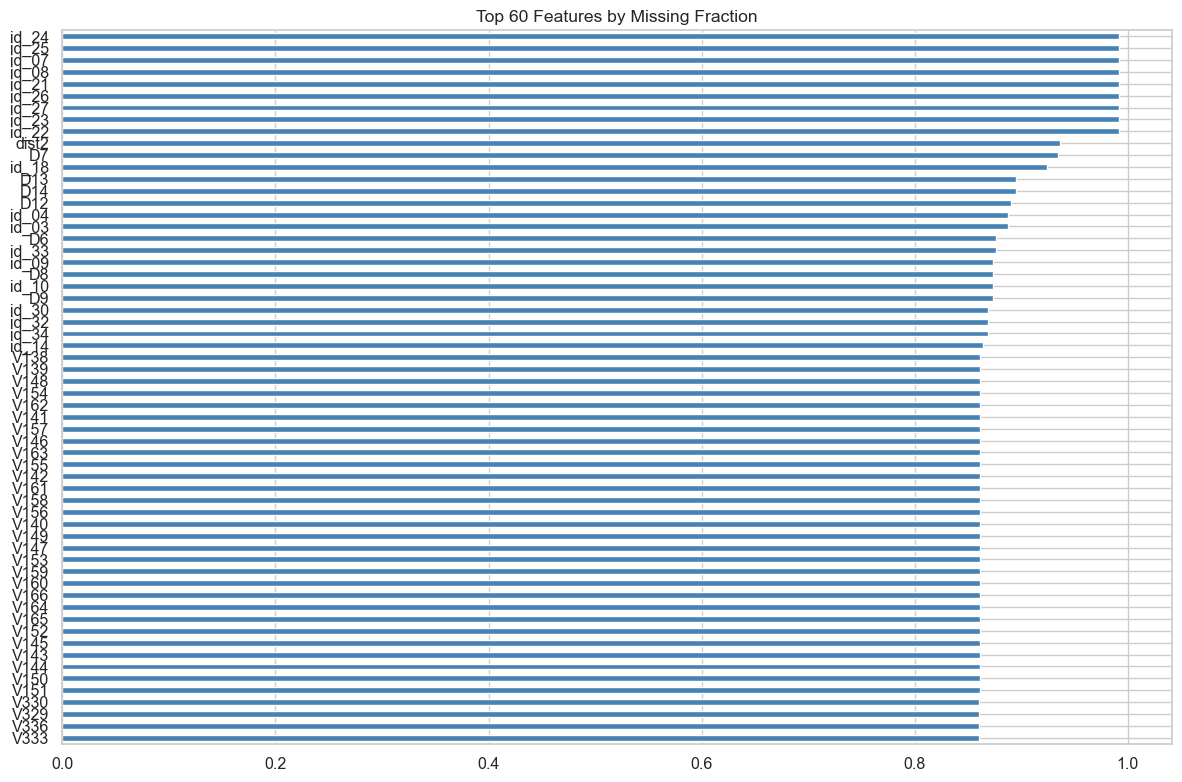

V-columns count: 339
V mean missing: 0.4303846896590721


In [5]:
missing = df.isnull().mean().sort_values(ascending=False)
print('Columns >50% missing:', (missing > 0.5).sum())
print('Columns with any missing:', (missing > 0).sum())

plt.figure(figsize=(12,8))
missing.head(60).plot.barh(color='steelblue')
plt.title('Top 60 Features by Missing Fraction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# V-columns summary
v_cols = [c for c in df.columns if c.startswith('V')]
print(f'V-columns count: {len(v_cols)}')
if v_cols:
    print('V mean missing:', df[v_cols].isnull().mean().mean())

## 3 — Class Distribution

Explore class imbalance and basic counts.

isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.4990%


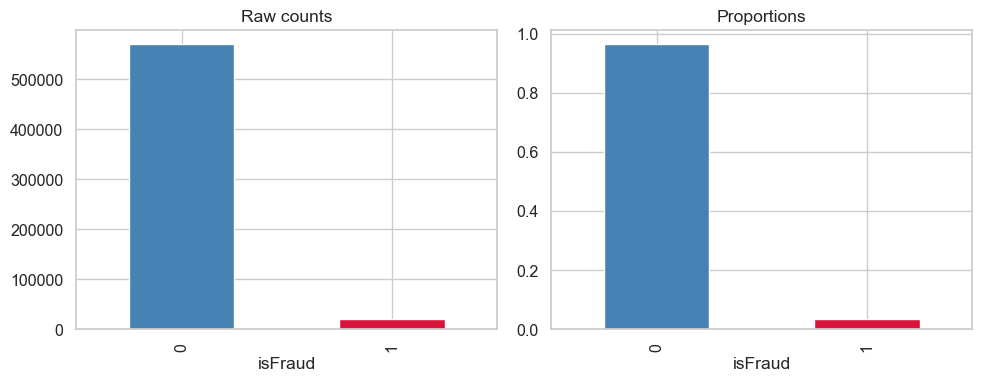

In [6]:
counts = df['isFraud'].value_counts()
print(counts)
print(f'Fraud rate: {df.isFraud.mean():.4%}')

fig, ax = plt.subplots(1,2,figsize=(10,4))
counts.plot.bar(ax=ax[0], color=['steelblue','crimson'])
ax[0].set_title('Raw counts')
(counts / counts.sum()).plot.bar(ax=ax[1], color=['steelblue','crimson'])
ax[1].set_title('Proportions')
plt.tight_layout()
plt.show()

## 4 — Transaction Amount

Investigate distribution of `TransactionAmt` and differences between classes.

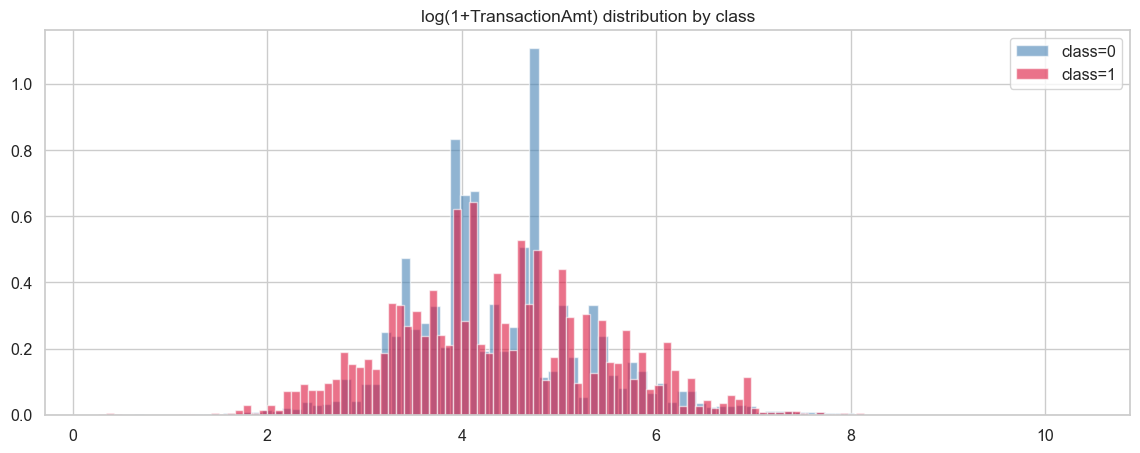

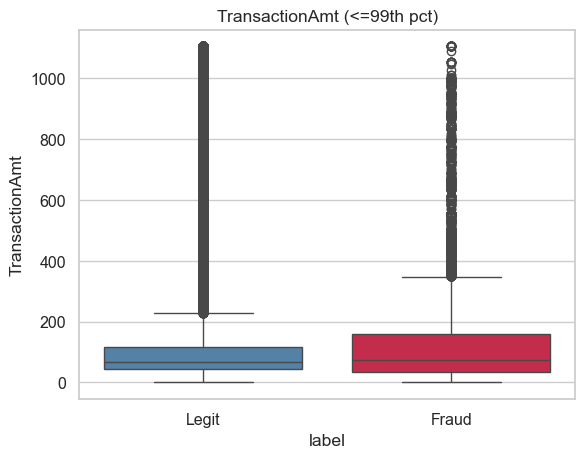

In [7]:
plt.figure(figsize=(14,5))
for label, color in [(0,'steelblue'), (1,'crimson')]:
    subset = df[df['isFraud']==label]['TransactionAmt'].dropna()
    plt.hist(np.log1p(subset), bins=100, alpha=0.6, color=color, density=True, label=f'class={label}')
plt.legend()
plt.title('log(1+TransactionAmt) distribution by class')
plt.show()

# Boxplot clipped at 99th percentile
clip = df['TransactionAmt'].quantile(0.99)
plot_df = df[df['TransactionAmt'] <= clip].copy()
plot_df['label'] = plot_df['isFraud'].map({0:'Legit',1:'Fraud'})
sns.boxplot(data=plot_df, x='label', y='TransactionAmt', palette=['steelblue','crimson'])
plt.title('TransactionAmt (<=99th pct)')
plt.show()

## 5 — Product & Card Features

Check how `ProductCD`, `card4`, and `card6` relate to fraud.

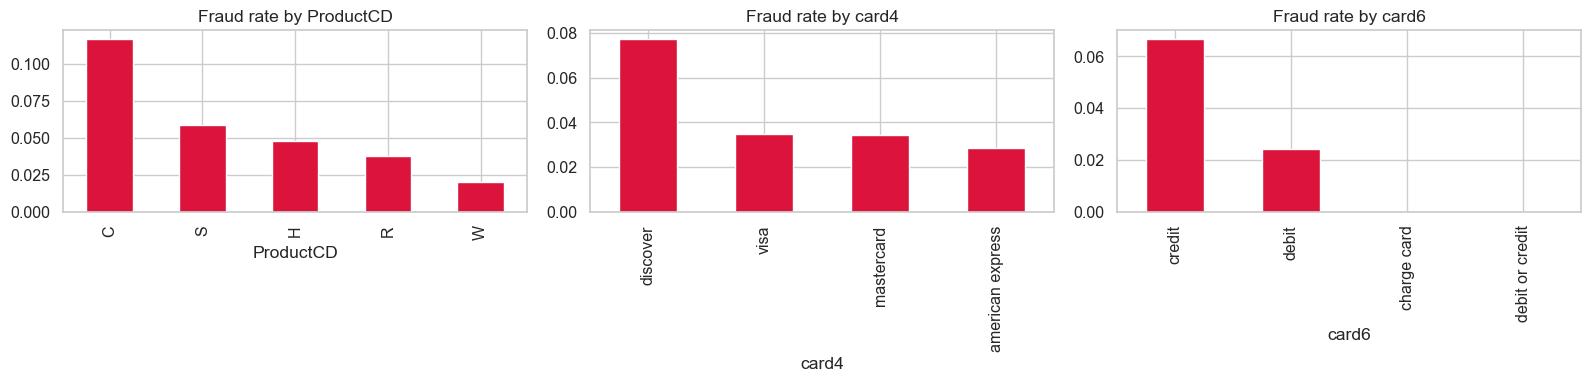

In [8]:
fig, axes = plt.subplots(1,3,figsize=(16,4))
for ax, col in zip(axes, ['ProductCD','card4','card6']):
    if col in df.columns:
        s = df.groupby(col)['isFraud'].agg(['count','mean']).sort_values('mean', ascending=False)
        s['mean'].plot.bar(ax=ax, color='crimson')
        ax.set_title(f'Fraud rate by {col}')
plt.tight_layout()
plt.show()

## 6 — Email Domain & Device

Analyze purchaser/recipient email domains and device information.

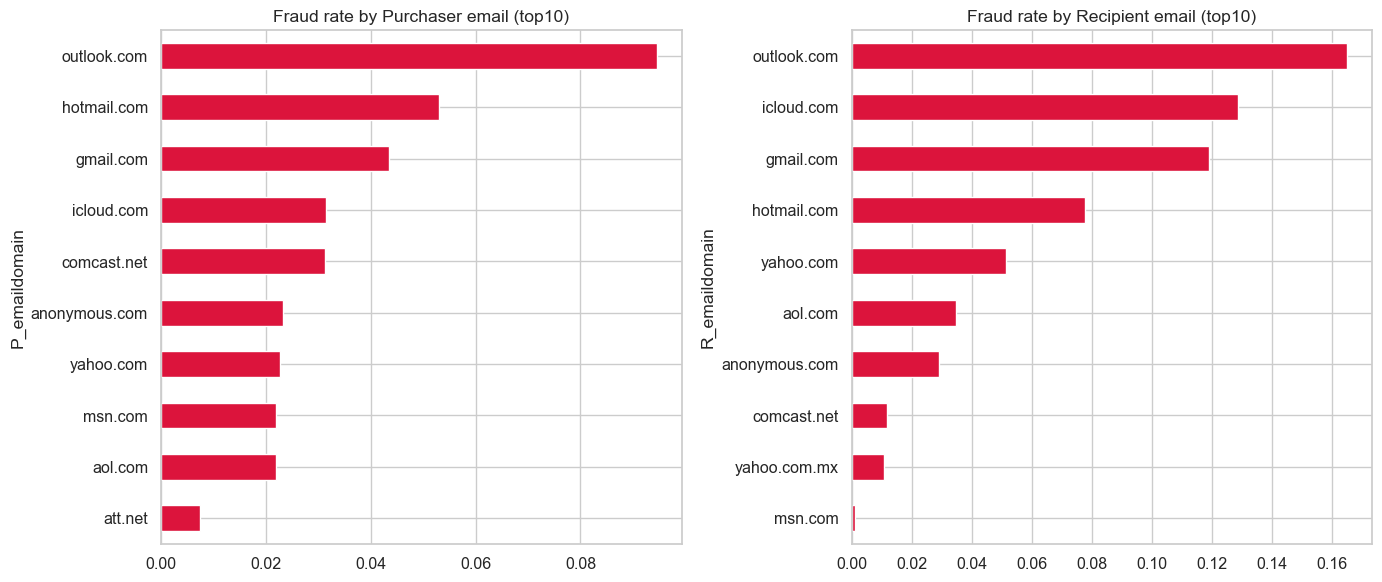

DeviceType NaN fraction: 0.7615572188166763


In [9]:
fig, axes = plt.subplots(1,2,figsize=(14,6))
for ax, col, title in [(axes[0], 'P_emaildomain','Purchaser'), (axes[1], 'R_emaildomain','Recipient')]:
    if col in df.columns:
        top = df[col].value_counts().head(10).index
        tmp = df[df[col].isin(top)].groupby(col)['isFraud'].mean().sort_values()
        tmp.plot.barh(ax=ax, color='crimson')
        ax.set_title(f'Fraud rate by {title} email (top10)')
plt.tight_layout()
plt.show()

# DeviceType
if 'DeviceType' in df.columns:
    print('DeviceType NaN fraction:', df['DeviceType'].isna().mean())

## 7 — Temporal Features

Create hour/day features from `TransactionDT` and inspect basic temporal patterns.

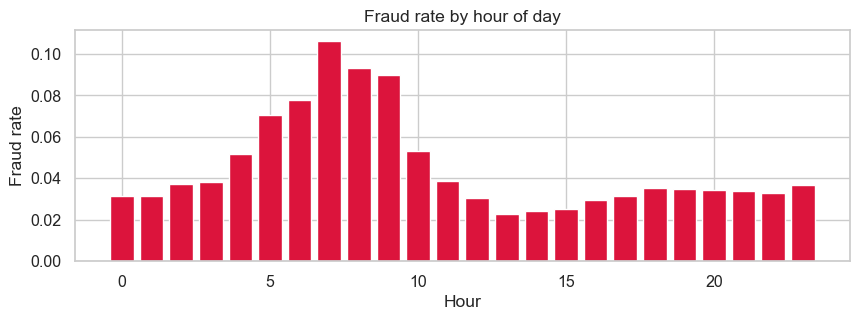

In [10]:
if 'TransactionDT' in df.columns:
    df['DT_hour'] = (df['TransactionDT'] % 86400) // 3600
    df['DT_day'] = df['TransactionDT'] // 86400
    hourly = df.groupby('DT_hour')['isFraud'].mean()
    plt.figure(figsize=(10,3))
    plt.bar(hourly.index, hourly.values, color='crimson')
    plt.title('Fraud rate by hour of day')
    plt.xlabel('Hour')
    plt.ylabel('Fraud rate')
    plt.show()
else:
    print('TransactionDT not present; skipping temporal analysis')

## 8 — Correlation with Target & Feature Selection Hints

Compute correlations for numeric features and surface the top signals to guide Notebook 02 feature engineering.

Top correlated numeric features:
V257   0.3831
V246   0.3669
V244   0.3641
V242   0.3606
V201   0.3280
V200   0.3188
V189   0.3082
V188   0.3036
V258   0.2972
V45    0.2818
V158   0.2781
V156   0.2760
V149   0.2733
V228   0.2689
V44    0.2604
V86    0.2518
V87    0.2517
V170   0.2498
V147   0.2429
V52    0.2395


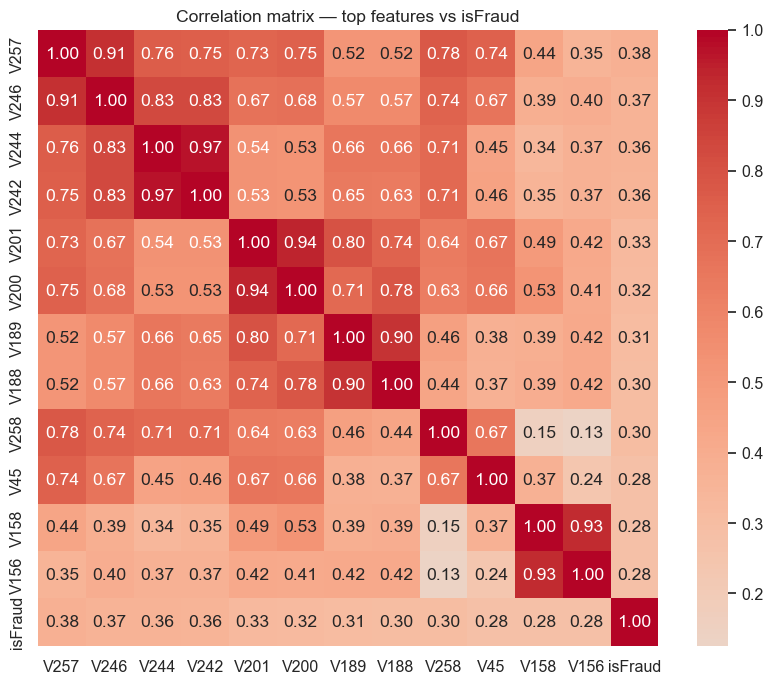

In [11]:
# Correlations (limit to numeric cols)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c != 'isFraud']
corr = df[num_cols + ['isFraud']].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
print('Top correlated numeric features:')
print(corr.head(20).to_string())

# Small heatmap for top features
top = corr.head(12).index.tolist() + ['isFraud']
cm = df[top].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation matrix — top features vs isFraud')
plt.show()

## Next steps

- Feature engineering: NaN patterns, aggregated balances (orig/dest deltas), frequency/target encoding, entity embeddings for PyTorch.
- Train baseline models (LR, RF, LightGBM, XGBoost, CatBoost).
- PyTorch tabular net with early stopping and calibration analysis.
- Save final model and preprocessing artifacts for Notebook 03 monitoring.